In [6]:
from jax import jit, random
import pandas as pd
from datetime import datetime, timedelta
import numpyro
from numpyro import distributions as dist
from numpyro import infer
import arviz as az
from IPython.display import Markdown
from plotly.express.colors import qualitative as qual_colours
from pathlib import Path
import math
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import Markdown
from matplotlib import pyplot as plt

from estival.sampling import tools as esamp

from emu_renewal.process import CosineMultiCurve
from emu_renewal.distributions import GammaDens
from emu_renewal.renew import RenewalModel
from emu_renewal.outputs import get_spaghetti_from_params, get_quant_df_from_spaghetti, plot_spaghetti
from emu_renewal.outputs import plot_uncertainty_patches, PANEL_SUBTITLES, plot_3d_spaghetti, plot_post_prior_comparison
from emu_renewal.calibration import StandardCalib
from emu_renewal.utils import get_adjust_idata_index, adjust_summary_cols

from plotting import plot_main
from utils import load_target_data, load_mobility_data, load_vaccination_data, load_variant_prevalence_data

## Setup country setting and load data

In [2]:
# Set country
country = 'Malaysia'

In [3]:
# load data
target_data = load_target_data(country)
mobility_data = load_mobility_data(country)
vaccination_data = load_vaccination_data(country)
variant_data = load_variant_prevalence_data(country)

## Specify renewal model and parameters

In [7]:
# Specify fixed parameters and get calibration data
proc_update_freq = 21
init_time = 50
data = target_data
pop = 33e6
analysis_start = datetime(2021, 5, 1)
analysis_end = datetime(2022, 4, 30)
init_start = analysis_start - timedelta(init_time)
init_end = analysis_start - timedelta(1)
select_data = data.loc[analysis_start: analysis_end]
init_data = data.resample("D").asfreq().interpolate().loc[init_start: init_end] / 7.0

In [8]:
proc_fitter = CosineMultiCurve()
renew_model = RenewalModel(pop, analysis_start, analysis_end, proc_update_freq, proc_fitter, GammaDens(), init_time, init_data, GammaDens())

In [9]:
# Define parameter ranges
priors = {
    "gen_mean": dist.TruncatedNormal(7.3, 0.5, low=1.0),
    "gen_sd": dist.TruncatedNormal(3.8, 0.5, low=1.0),
    "cdr": dist.Beta(15, 15), #16, 40
    "rt_init": dist.Normal(0.0, 0.25),
    "report_mean": dist.TruncatedNormal(8, 0.5, low=1.0),
    "report_sd": dist.TruncatedNormal(3, 0.5, low=1.0),
    "prop_immune": dist.Beta(3, 50)
}

## Model calibration

In [10]:
#| output: false
calib = StandardCalib(renew_model, priors, select_data, indicator='weekly_sum')
kernel = infer.NUTS(calib.calibration, dense_mass=True, init_strategy=infer.init_to_uniform(radius=0.5))
mcmc = infer.MCMC(kernel, num_chains=4, num_samples=4000, num_warmup=500) 
mcmc.run(random.PRNGKey(123))

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

## Wrangle model outputs

In [11]:
idata = az.from_dict(mcmc.get_samples(True))
idata_sampled = az.extract(idata, num_samples=800)
sample_params = esamp.xarray_to_sampleiterator(idata_sampled)

In [12]:
# get model results and outputs
def get_full_result(gen_mean, gen_sd, proc, cdr, rt_init, report_mean, report_sd, prop_immune):
    return renew_model.renewal_func(gen_mean, gen_sd, proc, cdr, rt_init, report_mean, report_sd, prop_immune)

full_wrap = jit(get_full_result)
panel_subtitles = ["weekly_sum"] + PANEL_SUBTITLES[1:]
spaghetti = get_spaghetti_from_params(renew_model, sample_params, full_wrap, outputs=panel_subtitles)
quantiles_df = get_quant_df_from_spaghetti(renew_model, spaghetti, quantiles=[0.05, 0.5, 0.95], outputs=panel_subtitles)

## Visualise model outputs and comparison against data

In [13]:
# Restrict range of mobility and vax data to analysis timeframe
mobility_data = mobility_data.loc[analysis_start:analysis_end]
vaccination_data = vaccination_data.loc[analysis_start:analysis_end]

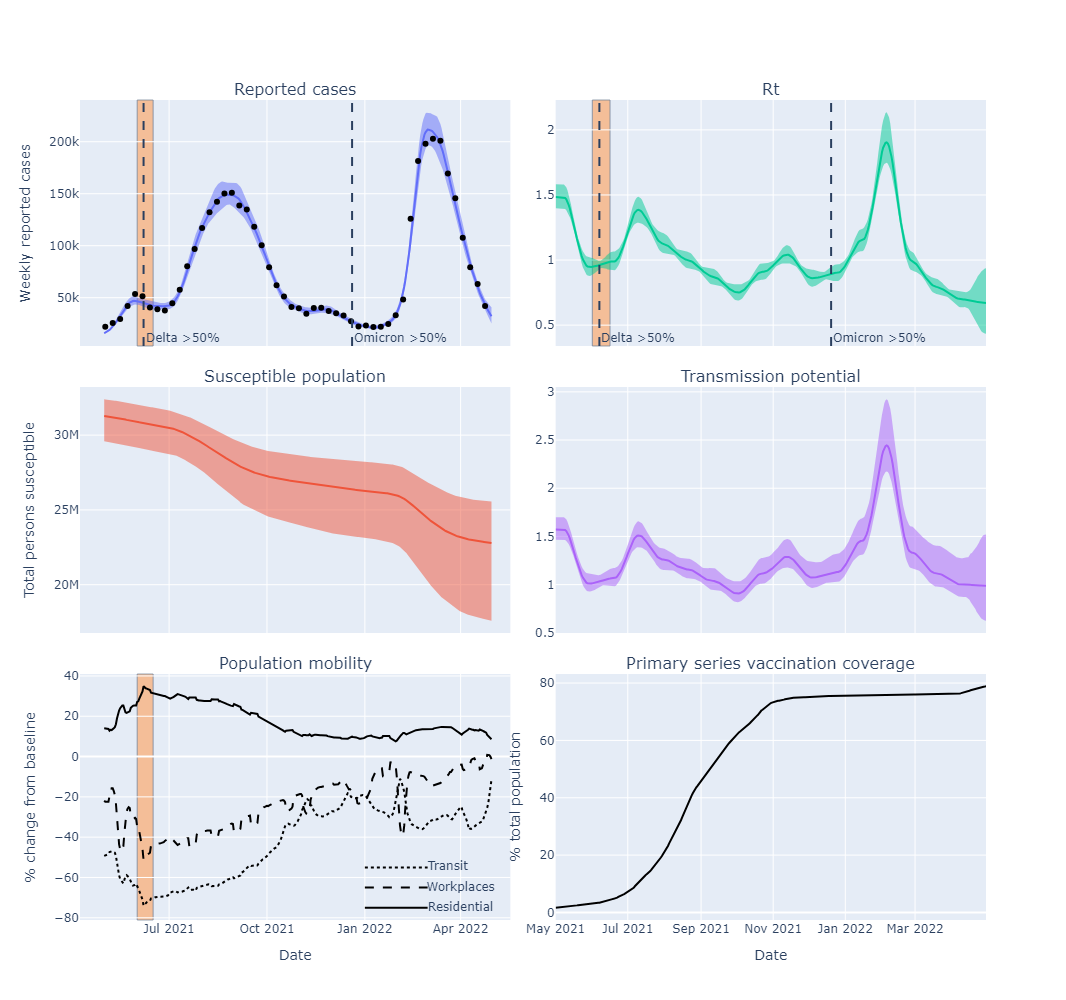

In [14]:
# Build main result plot/figure
fig = plot_main(quantiles_df, select_data, mobility_data, vaccination_data).update_layout(showlegend=False)

# Add interventions and variant prevalence to plots
number = 2

for i in range(number):
    fig.add_vrect(x0=datetime.strptime("2021-06-01", "%Y-%m-%d").timestamp() * 1000, x1=datetime.strptime("2021-06-16", "%Y-%m-%d").timestamp() * 1000,
             annotation_text="", annotation_position="right",
             fillcolor='#FFA15A', opacity=0.60, line_width=0.8, layer='below', row=1, col=i+1)
    
    delta = variant_data[variant_data['variant'] == 'Delta']
    delta_week = delta['week'].to_string(index=False)
    fig.add_vline(x=datetime.strptime(delta_week, "%Y-%m-%d").timestamp() * 1000, 
              annotation_text="Delta >50%", annotation_position="bottom right", row=1, col=i+1, line_dash="dash")
    
    omicron = variant_data[variant_data['variant'] == 'Omicron_BA1_2']
    omicron_week = omicron['week'].to_string(index=False)
    fig.add_vline(x=datetime.strptime(omicron_week, "%Y-%m-%d").timestamp() * 1000, 
              annotation_text="Omicron >50%", annotation_position="bottom right", row=1, col=i+1, line_dash="dash")
    
# add lockdown to mobility figure too
fig.add_vrect(x0=datetime.strptime("2021-06-01", "%Y-%m-%d").timestamp() * 1000, x1=datetime.strptime("2021-06-16", "%Y-%m-%d").timestamp() * 1000,
             annotation_text="", annotation_position="right",
             fillcolor='#FFA15A', opacity=0.60, line_width=0.8, layer='below', row=3, col=1)

fig['layout']['xaxis5']['title']='Date'
fig['layout']['xaxis6']['title']='Date'
fig['layout']['yaxis']['title']='Weekly reported cases'
fig['layout']['yaxis2']['title']=''
fig['layout']['yaxis3']['title']='Total persons susceptible'
fig['layout']['yaxis4']['title']='' 
fig['layout']['yaxis5']['title']='% change from baseline'
fig['layout']['yaxis6']['title']='% total population' 


fig.show()

## Exploring model outputs and calculating attack rates

In [13]:
# Quick code for exploring quantiles
print(quantiles_df.loc['2022-1-1':'2022-1-30'])

              weekly_sum                                 susceptibles  \
                    0.05          0.50          0.95             0.05   
2022-01-01   20951.92035  22425.286051   24032.59447  23154127.152272   
2022-01-02  20631.792646  22160.861933  23850.932052  23144334.650514   
2022-01-03  20328.529083  21897.141381  23668.018844  23134385.043773   
2022-01-04  20085.422683  21662.935494  23418.181048  23124253.051012   
2022-01-05  19807.005837  21480.568227  23300.767898  23113913.807164   
2022-01-06  19594.410615  21315.327934  23184.507388  23103343.375869   
2022-01-07  19427.744591  21207.079965  23138.880706   23092519.26978   
2022-01-08  19333.998791  21133.470354  23076.667783  23081420.990209   
2022-01-09  19283.928801  21104.386716  23071.523095  23070030.592031   
2022-01-10  19300.281044  21166.821309  23122.658013  23058333.268146   
2022-01-11  19392.740437  21238.788947  23184.681152  23046317.935893   
2022-01-12  19515.908039   21379.29147  23323.94518

In [14]:
# Find max value for specified date range
quantiles_df.loc['2022-1-1':'2022-2-20']['R'][0.95].max()

2.132722839358288

In [15]:
# quick code for calculating final attack rate
suscepts = quantiles_df['susceptibles']
suscepts['AR_05'] = 1 - suscepts[0.05]/pop
suscepts['AR_5'] = 1 - suscepts[0.50]/pop
suscepts['AR_95'] = 1- suscepts[0.95]/pop

C:\Users\ehug0006\AppData\Local\Temp\ipykernel_1492\1274767809.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ehug0006\AppData\Local\Temp\ipykernel_1492\1274767809.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ehug0006\AppData\Local\Temp\ipykernel_1492\1274767809.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

In [16]:
suscepts.tail(5)

0.05              0.5             0.95     AR_05  \
2022-04-26  17910350.965611  22851525.860157  25515255.926853  0.457262   
2022-04-27  17897305.908642  22845385.597736  25510701.380967  0.457657   
2022-04-28  17884624.372578  22839987.670702  25506379.497896  0.458042   
2022-04-29   17872375.00864  22835510.059967  25502277.573576  0.458413   
2022-04-30  17860598.397346  22831312.955133  25498383.405457   0.45877   

                AR_5     AR_95  
2022-04-26   0.30753   0.22681  
2022-04-27  0.307716  0.226948  
2022-04-28  0.307879  0.227079  
2022-04-29  0.308015  0.227204  
2022-04-30  0.308142  0.227322

## Calibration results

In [17]:
# summary table of calibration
az.summary(idata, hdi_prob=0.95)

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
cdr              0.480  0.095     0.297      0.667      0.002    0.002   
dispersion       0.091  0.012     0.069      0.114      0.000    0.000   
gen_mean         7.024  0.488     6.060      7.971      0.005    0.004   
gen_sd           3.924  0.509     2.923      4.912      0.005    0.003   
proc[0]         -0.444  0.074    -0.589     -0.300      0.001    0.000   
proc[1]          0.057  0.081    -0.100      0.215      0.001    0.001   
proc[2]          0.347  0.081     0.190      0.509      0.001    0.001   
proc[3]         -0.184  0.075    -0.329     -0.029      0.001    0.001   
proc[4]         -0.086  0.074    -0.235      0.054      0.001    0.001   
proc[5]         -0.107  0.076    -0.256      0.040      0.001    0.000   
proc[6]         -0.126  0.078    -0.278      0.027      0.001    0.000   
proc[7]          0.203  0.079     0.050      0.359      0.001    0.001   
proc[8]          0.143  0.077    -0.010      0.296      0.001    0.001   
proc[9]         -0.183  0.077    -0.344     -0.037      0.001    0.000   
proc[10]         0.055  0.077    -0.102      0.204      0.001    0.001   
proc[11]         0.250  0.079     0.095      0.404      0.001    0.001   
proc[12]         0.525  0.087     0.355      0.696      0.001    0.001   
proc[13]        -0.606  0.089    -0.780     -0.436      0.001    0.001   
proc[14]        -0.177  0.082    -0.340     -0.019      0.001    0.001   
proc[15]        -0.101  0.087    -0.270      0.071      0.001    0.001   
proc[16]        -0.037  0.248    -0.513      0.459      0.002    0.002   
proc[17]        -0.004  0.256    -0.501      0.506      0.003    0.002   
proc_dispersion  0.254  0.039     0.179      0.330      0.000    0.000   
prop_immune      0.049  0.025     0.008      0.099      0.001    0.000   
report_mean      7.417  0.471     6.457      8.306      0.007    0.005   
report_sd        3.123  0.504     2.128      4.091      0.008    0.005   
rt_init          0.454  0.047     0.364      0.545      0.001    0.000   

                 ess_bulk  ess_tail  r_hat  
cdr                1656.0     504.0    1.0  
dispersion         2426.0     604.0    1.0  
gen_mean           8794.0   10673.0    1.0  
gen_sd            10753.0    8179.0    1.0  
proc[0]           13759.0    9493.0    1.0  
proc[1]            7029.0    5066.0    1.0  
proc[2]            6629.0    6027.0    1.0  
proc[3]            4273.0    1391.0    1.0  
proc[4]            8982.0   10801.0    1.0  
proc[5]           13494.0   11511.0    1.0  
proc[6]           12080.0   12272.0    1.0  
proc[7]           10228.0   11186.0    1.0  
proc[8]           11641.0   11526.0    1.0  
proc[9]           13254.0   11783.0    1.0  
proc[10]          15210.0   11051.0    1.0  
proc[11]           9149.0   11633.0    1.0  
proc[12]          13480.0   11522.0    1.0  
proc[13]           8927.0   11154.0    1.0  
proc[14]           8696.0    8651.0    1.0  
proc[15]           8828.0    4427.0    1.0  
proc[16]          10450.0    9030.0    1.0  
proc[17]           8932.0   10589.0    1.0  
proc_dispersion    9205.0    6929.0    1.0  
prop_immune        1145.0     381.0    1.0  
report_mean        5022.0    5178.0    1.0  
report_sd          4293.0    7854.0    1.0  
rt_init            4640.0    7985.0    1.0

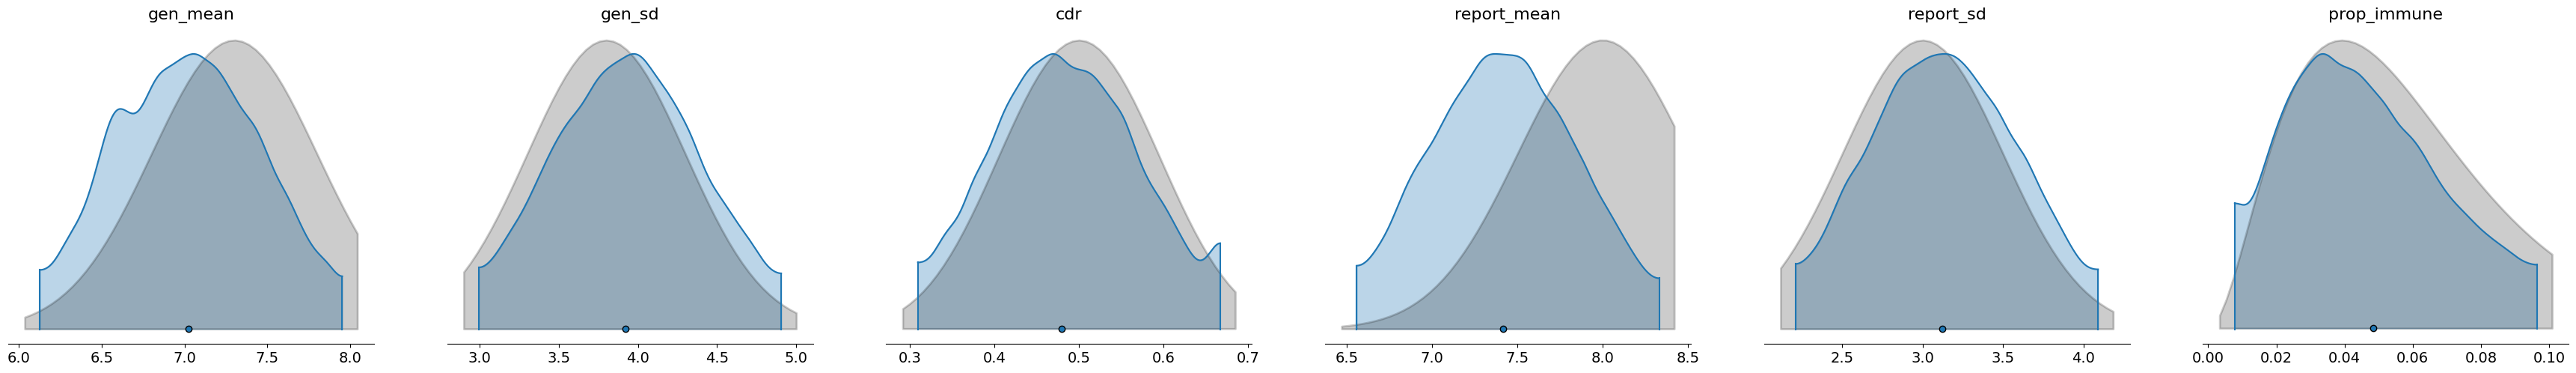

In [18]:
# prior-posterior comparison plot
plot_post_prior_comparison(idata, [p for p in priors.keys() if p !="rt_init"],priors);
#plt.savefig('malaysia_posterior.png')

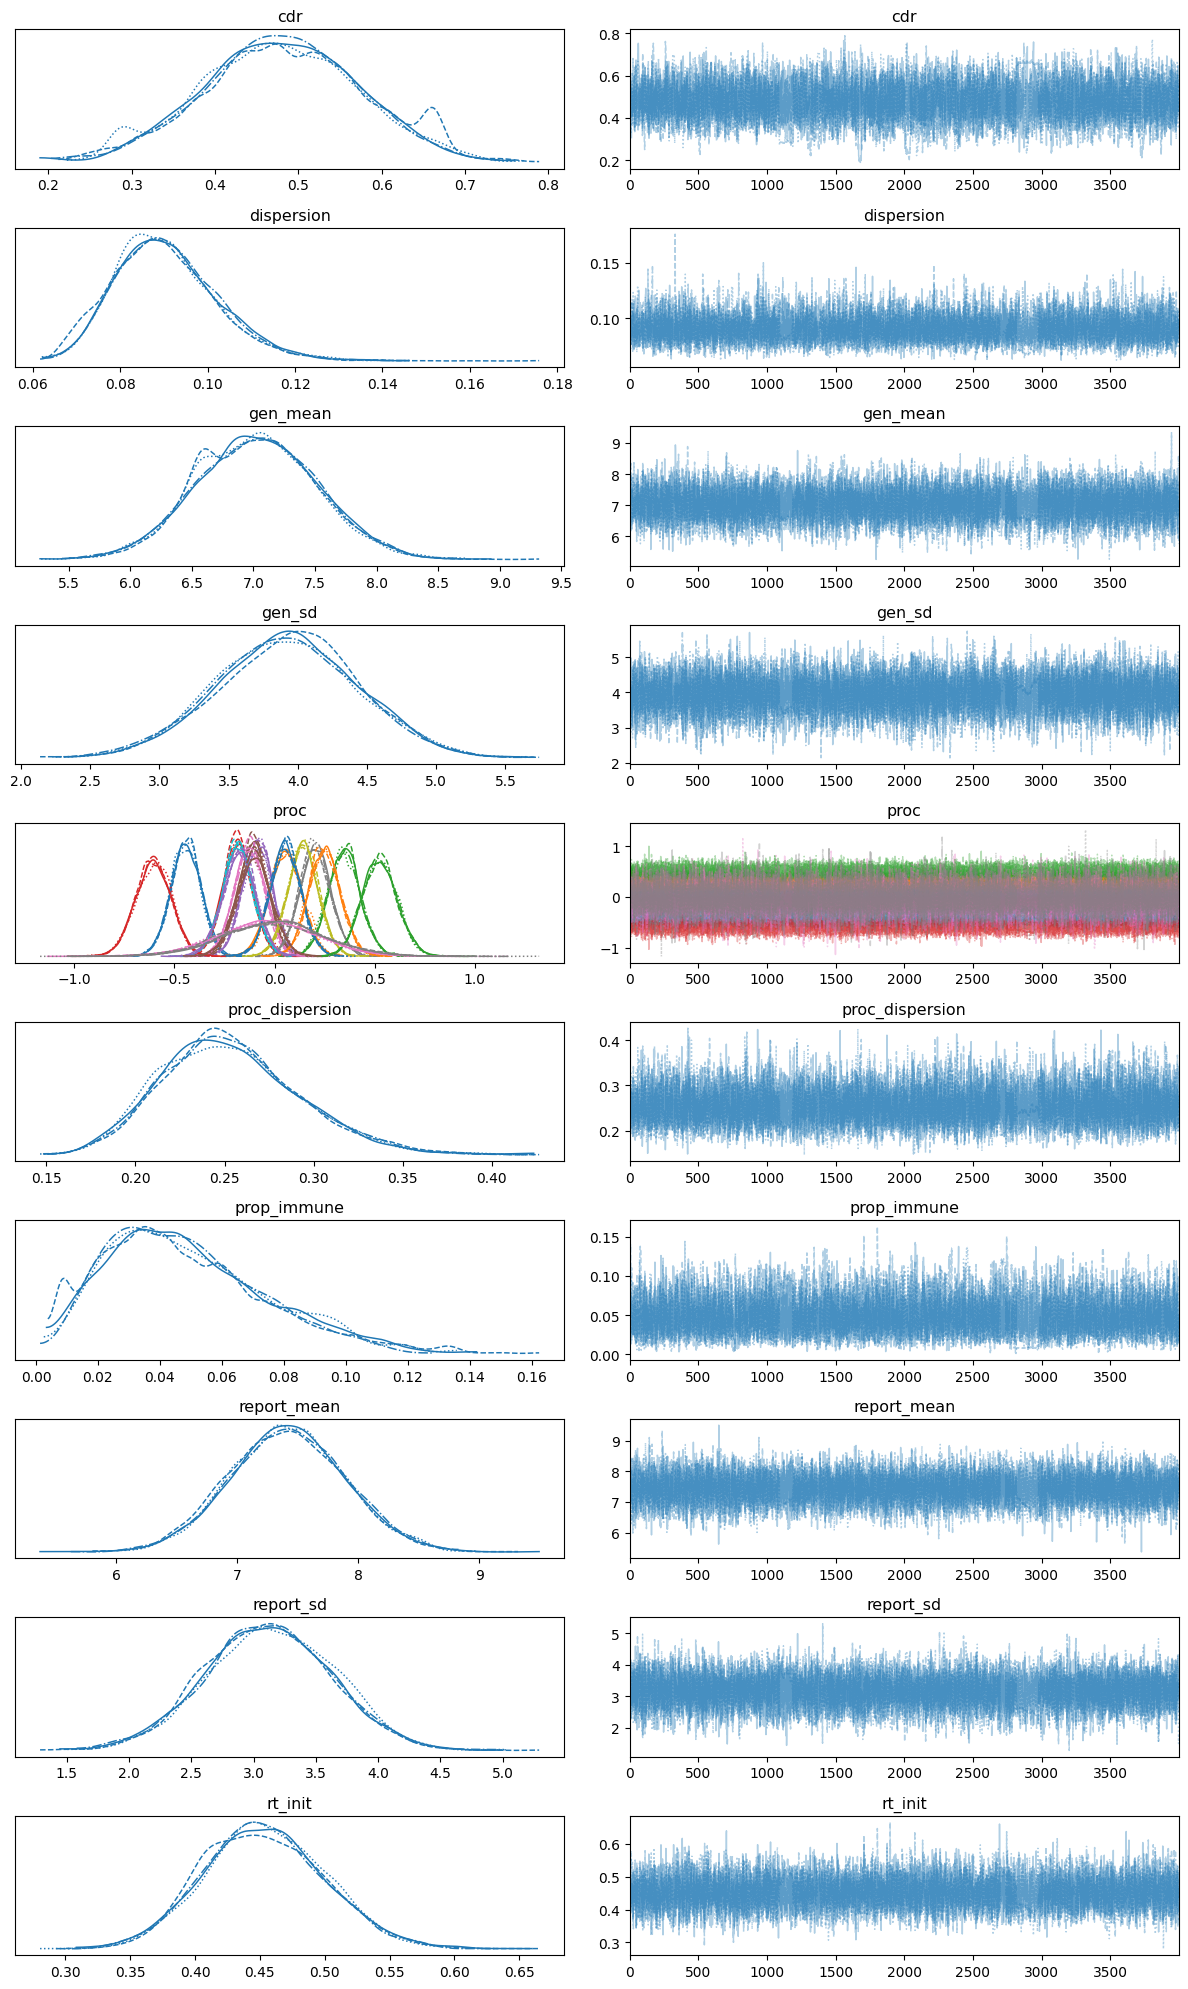

In [19]:
# trace and posterior plot
az.plot_trace(idata)
plt.tight_layout()
#plt.savefig('malaysia_trace.png')

## Model descriptions and table for supplement

In [20]:
Markdown('## Model description')

## Model description

In [ ]:
Markdown(renew_model.get_description())

In [ ]:
Markdown('## Calibration')

In [ ]:
Markdown(calib.get_description())

In [ ]:
param_sum = az.summary(idata)
params = [i for i in param_sum.index if not any(s in i for s in ["proc", "rt_init"])]
cols = [i for i in param_sum.columns if not any(s in i for s in ["mcse_"])]
short_param_sum = param_sum.loc[params, cols]
short_param_sum.columns = short_param_sum.columns.str.replace("_", " ").str.replace("ess", "ESS").str.replace("hdi", "HDI")
param_str_conv = {
    "cdr": "CDR",
    "gen_mean": "generation distribution mean (days)",
    "gen_sd": "generation distribution SD (days)",
    "report_mean": "reporting distribution mean (days)",
    "report_sd": "reporting distribution SD (days)",
}
col_str_conv = {
    "r hat": "R-hat",
    "sd": "SD",
}
short_param_sum = short_param_sum.rename(param_str_conv)
short_param_sum = short_param_sum.rename(col_str_conv, axis=1)
short_param_sum

## Export model, target and comparison data to excel for submission

In [15]:
with pd.ExcelWriter('Malaysia_results.xlsx') as writer:  
    quantiles_df.to_excel(writer, sheet_name='Model_outputs')
    select_data.to_excel(writer, sheet_name='WHO_weekly_cases')
    mobility_data.to_excel(writer, sheet_name='Mobility_data')
    vaccination_data.to_excel(writer, sheet_name='Vaccination_data')